# Capstone Project - The Battle of the Neighborhoods
### Applied Data Science Capstone by IBM/Coursera

## Table of contents
* [Introduction: Business Problem](#introduction)
* [Data](#data)
* [Methodology](#methodology)
* [Analysis](#analysis)
* [Results and Discussion](#results)
* [Conclusion](#conclusion)

## Introduction <a name="introduction"></a>

Salt Lake County, Utah is one of the fastest-growing cities in the United States. As a result, home sales prices have been gradually increasing.

In this project, we will examine **home sales prices in Salt Lake County, Utah**. We also analyze the home sales data to answer the question whether the number of venues around a home impact its price. This data analysis will be beneficial to people who are currently looking to buy an affordable home in Salt Lake County.

## Data <a name="data"></a>

For this problem, we will need the following data:
* List of homes for sale in Salt Lake County.
* Data of venues in Salt Lake County.
* Data of coordinates of venues and homes in Salt Lake County.

To acquire these data, we use the sources:
* The list of homes for sale in Salt Lake County downloaded from redfin.com.
* Number of venues, their coordinates and categories using Foursquare API.
* Coordinates of homes using Google Maps API geocoding.

In [52]:
import numpy as np # library to handle data in a vectorized manner

import pandas as pd # library for data analsysis
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

import json # library to handle JSON files

import requests # library to handle requests

# Matplotlib and associated plotting modules
import matplotlib.cm as cm
import matplotlib.colors as colors
import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline

# import k-means from clustering stage
from sklearn.cluster import KMeans

!conda install -c conda-forge folium=0.5.0 --yes --quiet
import folium # map rendering library

print('Libraries imported.')

Libraries imported.


#### Let's create a list of cities in Salt Lake County with their coordinates.

We load the list of homes to a dataframe, extract cities, and create another dataframe for them.

First, let's clean the data.

In [3]:
homes = pd.read_csv('salt_lake_houses.csv')
homes.drop(columns=['SALE TYPE', 'SOLD DATE', 'STATE OR PROVINCE', 'DAYS ON MARKET', '$/SQUARE FEET', 'HOA/MONTH', 'STATUS'], inplace = True)
homes.drop(columns=['NEXT OPEN HOUSE START TIME', 'NEXT OPEN HOUSE END TIME', 'URL (SEE http://www.redfin.com/buy-a-home/comparative-market-analysis FOR INFO ON PRICING)', 'SOURCE', 'MLS#', 'FAVORITE', 'INTERESTED'], inplace = True)
homes.columns = map(str.lower, homes.columns) # lowercase columns' names
homes.loc[homes.city == 'Draper (UT Cnty)', 'city'] = 'Draper'
homes.loc[homes.city == 'Snowbird', 'city'] = 'Alta'
homes.loc[homes.city == 'Solitude', 'city'] = 'Brighton'
homes.drop(homes[homes['city'] == 'Other City - Utah'].index, inplace = True)
homes.drop(homes[homes['city'] == 'Park City'].index, inplace = True)
homes.rename(columns={'property type': 'type', 'zip or postal code': 'zipcode'}, inplace=True)
homes.head()

,type,address,city,zipcode,price,beds,baths,location,square feet,lot size,year built,latitude,longitude
0,Condo/Co-op,265 E 8880 S #3,Sandy,84070,165000,1.0,1.0,Sandy; Draper; Granite; Wht Cty,740.0,435.0,1975.0,40.590439,-111.882837
1,Condo/Co-op,117 E Calbourne Ln #I8,Sandy,84070,249900,3.0,2.0,Sandy; Draper; Granite; Wht Cty,1185.0,435.0,2008.0,40.601340,-111.887658
2,Single Family Residential,2581 S Melville Dr,Magna,84044,260000,3.0,1.5,Magna; Taylrsvl; Wvc; Slc,1108.0,4791.0,1982.0,40.713914,-112.083035
3,Townhouse,14394 S Ferndale Way,Herriman,84096,269000,3.0,2.5,Wj; Sj; Rvrton; Herriman; Bingh,1807.0,871.0,2015.0,40.489591,-111.995767
4,Condo/Co-op,2070 E 3335 S #2,Salt Lake City,84109,218000,2.0,1.0,Salt Lake City; Ft Douglas,840.0,NaN,1965.0,40.699403,-111.831397


In [4]:
cities = homes[['city']].drop_duplicates().reset_index(drop=True)
cities.head(5)

,city
0,Sandy
1,Magna
2,Herriman
3,Salt Lake City
4,West Jordan


In [5]:
print(cities.shape)

(21, 1)


There are **26 cities** in Salt Lake County. Now let's find their coordinates using Google API.

In [35]:
# @hidden_cell
GOOGLE_API_KEY = 'your key'
FOURSQUARE_CLIENT_ID = 'your id' # your Foursquare ID
FOURSQUARE_CLIENT_SECRET = 'your key' # your Foursquare Secret
VERSION = '20200110' # Foursquare API version
LIMIT = 200

In [7]:
def get_coordinates(address):
    lat, lng = None, None
    api_key = GOOGLE_API_KEY
    base_url = "https://maps.googleapis.com/maps/api/geocode/json"
    endpoint = f"{base_url}?address={address}&key={api_key}"

    r = requests.get(endpoint)
    if r.status_code not in range(200, 299):
        return None, None
    try:
        results = r.json()['results'][0]
        lat = results['geometry']['location']['lat']
        lng = results['geometry']['location']['lng']
    except:
        pass
    return lat, lng

In [8]:
address = 'Salt Lake City, Utah'
center = get_coordinates(address)
print('Coordinate of {}: {}'.format(address, center))

Coordinate of Salt Lake City, Utah: (40.7607793, -111.8910474)


In [9]:
cities = pd.concat([cities,pd.DataFrame(columns=['latitude', 'longitude'])])
cities.head()

,city,latitude,longitude
0,Sandy,NaN,NaN
1,Magna,NaN,NaN
2,Herriman,NaN,NaN
3,Salt Lake City,NaN,NaN
4,West Jordan,NaN,NaN


In [10]:
for index, row in cities.iterrows():
    address = row['city'] + ", Utah"
    coordinates = get_coordinates(address)
    row['latitude'] = coordinates[0]
    row['longitude'] = coordinates[1]

In [11]:
cities.sort_values(by=['city'])

,city,latitude,longitude
20,Alta,40.5888,-111.638
14,Bluffdale,40.4897,-111.939
13,Brighton,40.6038,-111.582
8,Cottonwood Heights,40.6183,-111.816
7,Draper,40.5247,-111.864
19,Emigration Canyon,40.7667,-111.767
2,Herriman,40.5141,-112.033
16,Holladay,40.6688,-111.825
10,Kearns,40.6599,-111.996
1,Magna,40.7091,-112.102


#### Now we have the list of cities, let's display them on a map.

In [12]:
address = 'Salt Lake County, Utah'
center = get_coordinates(address)
latitude = center[0]
longitude = center[1]

# create map of Salt Lake City using latitude and longitude values
map_saltlake = folium.Map(location=[latitude, longitude], zoom_start=11)

# add markers to map
for lat, lng, city in zip(cities['latitude'], cities['longitude'], cities['city']):
    label = '{}'.format(city)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_saltlake)  
    
map_saltlake

#### Next, we need data of venues around homes for sale in Salt Lake City.

Let's first narrow our homes data to Salt Lake City and Single Family Residential.

In [56]:
homes_saltlake = homes.loc[(homes['city'] == 'Salt Lake City') & (homes['location'].str.contains('Salt Lake City', regex=False)) & (homes['type'] == 'Single Family Residential')]
homes_saltlake.head()

,type,address,city,zipcode,price,beds,baths,location,square feet,lot size,year built,latitude,longitude
65,Single Family Residential,1230 S Montgomery,Salt Lake City,84104,259900,3.0,1.00,Salt Lake City; Rose Park,1132.0,7840.0,1952.0,40.742675,-111.936357
124,Single Family Residential,1063 W 400 S,Salt Lake City,84104,255000,3.0,0.75,Salt Lake City; Rose Park,814.0,3484.0,1900.0,40.760434,-111.921625
148,Single Family Residential,121 W Angelo Ave,Salt Lake City,84115,249900,3.0,1.00,Salt Lake City; So. Salt Lake,1008.0,5662.0,1945.0,40.702598,-111.894656
170,Single Family Residential,3558 S 900 E,Salt Lake City,84106,245000,2.0,1.00,Salt Lake City; So. Salt Lake,1381.0,435.0,1920.0,40.693964,-111.866110
199,Single Family Residential,1416 W Van Buren Ave,Salt Lake City,84104,220000,2.0,1.00,Salt Lake City; Rose Park,644.0,13068.0,1912.0,40.736211,-111.931452


Let's visualize this data.

In [57]:
address = 'Salt Lake City, Utah'
center = get_coordinates(address)
latitude = center[0]
longitude = center[1]

# create map of Salt Lake City using latitude and longitude values
map_homes_saltlake = folium.Map(location=[latitude, longitude], zoom_start=12)

# add markers to map
for lat, lng, city in zip(homes_saltlake['latitude'], homes_saltlake['longitude'], homes_saltlake['address']):
    label = '{}'.format(address)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=2,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_homes_saltlake)  
    
map_homes_saltlake

Now, we will create another dataframe that has venues within 1km around homes. 

In [36]:
def getNearbyVenues(names, latitudes, longitudes, radius):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            FOURSQUARE_CLIENT_ID, 
            FOURSQUARE_CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
        try:    
            # make the GET request
            results = requests.get(url).json()["response"]['groups'][0]['items']

            # return only relevant information for each nearby venue
            venues_list.append([(
                name, 
                lat, 
                lng, 
                v['venue']['name'], 
                v['venue']['location']['lat'], 
                v['venue']['location']['lng'],  
                v['venue']['categories'][0]['name']) for v in results])
        except:
            venues_list.append([""])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['home address', 
                  'home latitude', 
                  'home longitude', 
                  'venue', 
                  'venue latitude', 
                  'venue longitude', 
                  'venue category']
    
    return(nearby_venues)

In [58]:
homes_saltlake_venues = getNearbyVenues(names=homes_saltlake['address'],
                                  latitudes=homes_saltlake['latitude'],
                                  longitudes=homes_saltlake['longitude'],
                                  radius=1000
                                  )

In [59]:
print(homes_saltlake_venues.shape)
homes_saltlake_venues.head()

(6990, 7)


,home address,home latitude,home longitude,venue,venue latitude,venue longitude,venue category
0,1230 S Montgomery,40.742675,-111.936357,La Hacienda,40.742357,-111.939540,Mexican Restaurant
1,1230 S Montgomery,40.742675,-111.936357,Hook & Ladder Co No. 13,40.740360,-111.928645,Fish & Chips Shop
2,1230 S Montgomery,40.742675,-111.936357,Chase Bank,40.740972,-111.938296,Bank
3,1230 S Montgomery,40.742675,-111.936357,Gonzalez Market,40.742786,-111.939854,Grocery Store
4,1230 S Montgomery,40.742675,-111.936357,Sapp Brothers Café,40.739766,-111.946267,American Restaurant


## Methodology <a name="methodology"></a>

We use Google Geocoding API to obtain the coordinates of homes and also the coordinates of cities in Salt Lake County. 
To compare the prices among cities, we calculate the average price of each city, and show the top 5 cities. Then we will visualize the average prices using a Choropleth map.
To analyze the impact of venues to home prices, we will get the number of venues per home and the number of venue categories per home by counting venues and venue categories based on the data. From that, we will use Scatter plots to visualize the relation between them to see if we can build a model for them.

## Analysis <a name="analysis"></a>

#### Let's compare the average homes prices among the cities in Sale Lake County, and see which city has the highest average homes price.

In [39]:
homes_avg = homes[['city', 'price']].groupby('city').mean().round(0).reset_index()

In [40]:
homes_avg.head()

,city,price
0,Alta,909869.0
1,Bluffdale,524368.0
2,Brighton,921562.0
3,Cottonwood Heights,806452.0
4,Draper,776492.0


We will show the top five cities with the highest price.

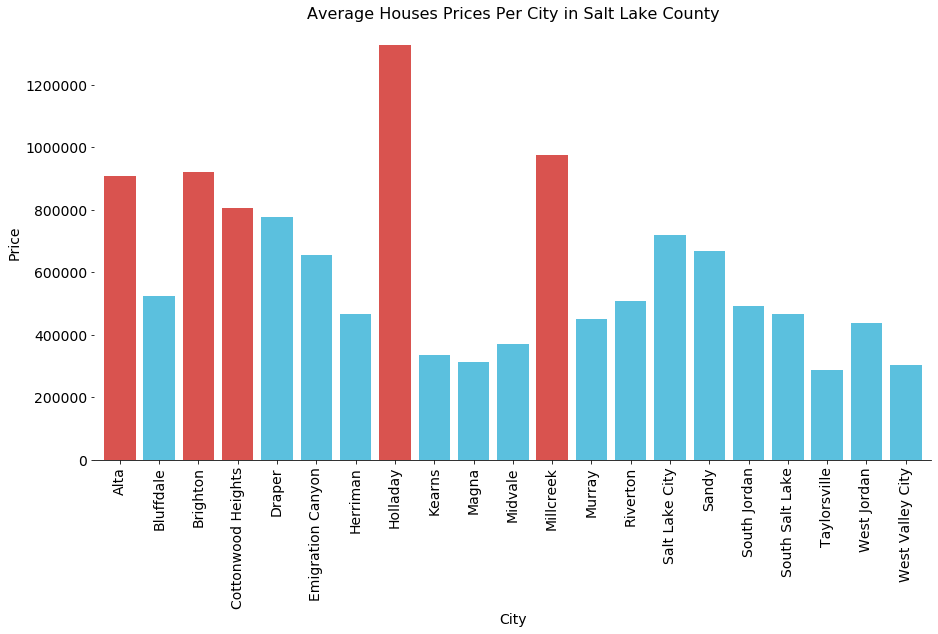

In [41]:
avg_sort = homes_avg.sort_values(by='price', ascending=False).reset_index(drop=True)
flag = avg_sort.loc[4, 'price']
colors = ['#5bc0de' if (x < flag) else '#d9534f' for x in homes_avg['price'] ]

ax = homes_avg.plot(kind='bar', x='city', y='price', color=colors, figsize=(15, 8), width = 0.8, fontsize=14, legend=False)
ax.set_xlabel('City', fontsize=14)
ax.set_ylabel('Price', fontsize=14)
ax.set_title("Average Houses Prices Per City in Salt Lake County", fontsize=16)
ax.spines['left'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

As we can see, the top 5 cities are as follows:

In [42]:
avg_sort.head()

,city,price
0,Holladay,1326851.0
1,Millcreek,976709.0
2,Brighton,921562.0
3,Alta,909869.0
4,Cottonwood Heights,806452.0


| City               | Avg. Price |
|--------------------|-----------:|
| Holladay           | \\$1,326,851 |
| Millcreek          |   \\$976,709 |
| Brighton           |   \\$921,562 |
| Alta               |   \\$909,869 |
| Cottonwood Heights |   \\$806,452 |

We will use a choropleth map to visualize the average price per city.

In [43]:
saltlake_geo = r'salt_lake_county.json' # geojson file
address = 'Salt Lake County, Utah'
center = get_coordinates(address)
latitude = center[0]
longitude = center[1]
map_choropleth = folium.Map(location=[latitude, longitude], zoom_start=10)

In [44]:
map_choropleth.choropleth(
    geo_data=saltlake_geo,
    data=homes_avg,
    columns=['city', 'price'],
    key_on='feature.properties.name',
    fill_color='YlOrRd', 
    fill_opacity=0.7, 
    line_opacity=0.2,
    legend_name='Average Homes Price'
)
for lat, lng, city in zip(cities['latitude'], cities['longitude'], cities['city']):
    label = '{}'.format(city)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_choropleth) 

map_choropleth

It looks like homes near Wasatch Range have higher prices.

#### Now, let's find out if the number of venues near a home impacts the home's price.

First, we need total number of venues around homes.

In [60]:
homes_sl_ven_count = homes_saltlake_venues[['home address', 'venue']].groupby('home address').count().reset_index()
homes_sl_ven_count.head()

,home address,venue
0,1025 E Northbonneville Dr,5
1,1030 E 100 S,45
2,1041 S Military Dr,15
3,1050 N 1500 W,15
4,1059 W 400 N,37


In [61]:
homes_sl_ven_count = homes_sl_ven_count.merge(homes_saltlake[['address', 'price']], left_on='home address', right_on='address')[['home address', 'venue', 'price']]
homes_sl_ven_count.head()

,home address,venue,price
0,1025 E Northbonneville Dr,5,1199900
1,1030 E 100 S,45,860000
2,1041 S Military Dr,15,1475000
3,1050 N 1500 W,15,289000
4,1059 W 400 N,37,370000


We have the numbers we need, now we will use Scatter Plot to see the relation between Price and the number of venues.

In [62]:
x = homes_sl_ven_count['venue']
y = homes_sl_ven_count['price']
fit = np.polyfit(x, y, deg=1)

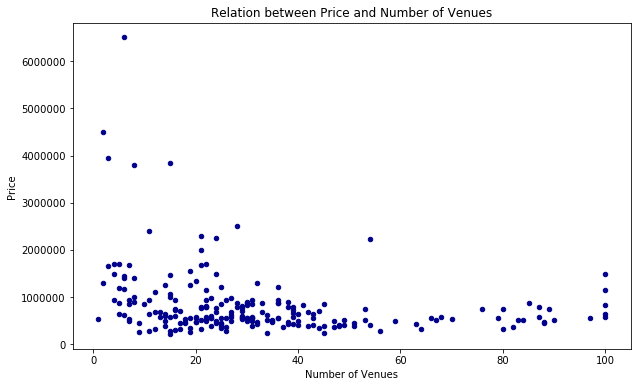

In [76]:
homes_sl_ven_count.plot(kind='scatter', x='venue', y='price', figsize=(10, 6), color='darkblue')

plt.title('Relation between Price and Number of Venues')
plt.xlabel('Number of Venues')
plt.ylabel('Price')

# plot line of best fit
#plt.plot(x, fit[0] * x + fit[1], color='red')
#plt.annotate('y={0:.0f} x + {1:.0f}'.format(fit[0], fit[1]), xy=(2000, 150000))

plt.show()

According to the above chart, we can say that there is not relation between Price and the number of venues of a home.

In [73]:
homes_sl_cat_count = homes_saltlake_venues.groupby(by='home address', as_index=False).agg({'venue category': pd.Series.nunique})
homes_sl_cat_count = homes_sl_cat_count.merge(homes_saltlake[['address', 'price']], left_on='home address', right_on='address')[['home address', 'venue category', 'price']]
homes_sl_cat_count.head()

,home address,venue category,price
0,1025 E Northbonneville Dr,2,1199900
1,1030 E 100 S,36,860000
2,1041 S Military Dr,12,1475000
3,1050 N 1500 W,11,289000
4,1059 W 400 N,26,370000


In [74]:
x = homes_sl_cat_count['venue category']
y = homes_sl_cat_count['price']
fit = np.polyfit(x, y, deg=1)

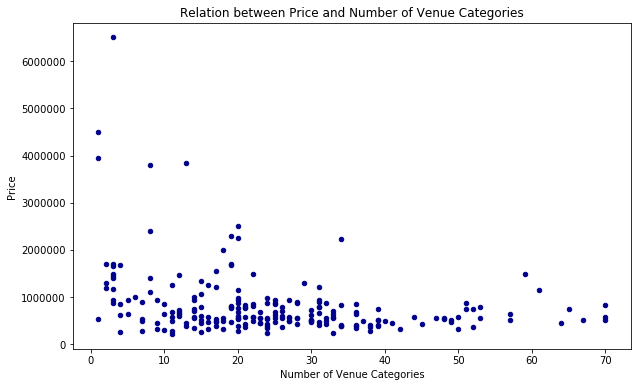

In [77]:
homes_sl_cat_count.plot(kind='scatter', x='venue category', y='price', figsize=(10, 6), color='darkblue')

plt.title('Relation between Price and Number of Venue Categories')
plt.xlabel('Number of Venue Categories')
plt.ylabel('Price')

# plot line of best fit
#plt.plot(x, fit[0] * x + fit[1], color='red')
#plt.annotate('y={0:.0f} x + {1:.0f}'.format(fit[0], fit[1]), xy=(2000, 150000))

plt.show()

The above chart also shows there is no relation between Price and the number of venue categories of a home.

## Results and Discussion <a name="results"></a>

The top five cities which have the highest home prices are: Holladay, Millcreek, Brighton, Alta, and Cottonwood Heights. The interesting point is these cities are near the Wasatch Range. In other words, homes near the Wasatch Range have higher prices than other homes.
The number of venues and the number of venue categories near a home don't impact its price. This is also interesting because most people believe that if a home has many venues nearby, its price will be high. There might be some other factors that impact the price but they are out of scope of this project.

## Conclusion <a name="conclusion"></a>

As Utah is one of the most growing states in the U.S., many people come here to find new opportunities. As a result, the demand for owning a home has been increasing. This project has given an insight of home prices which will help home buyers have more information before deciding to buy a home.